In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import importance_sample_lib as imp_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5,
                        num_images=100, brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

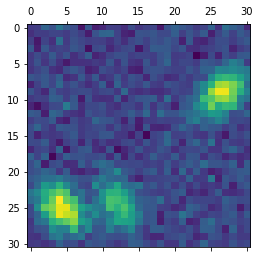

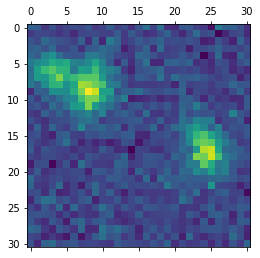

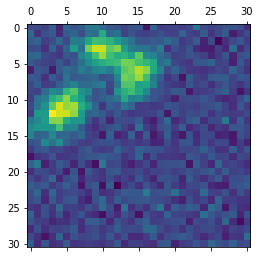

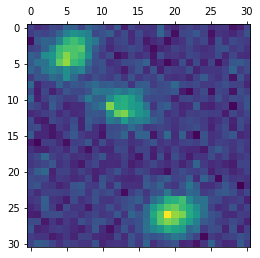

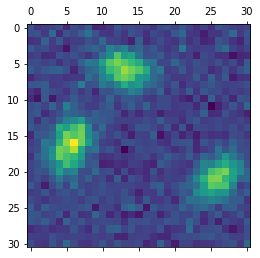

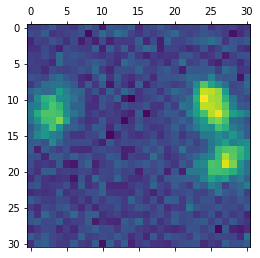

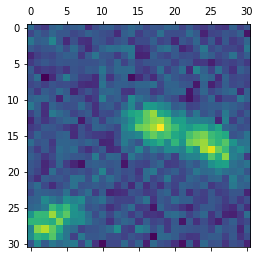

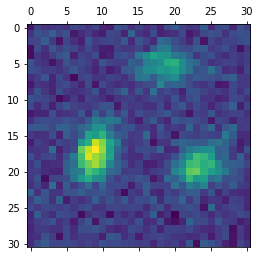

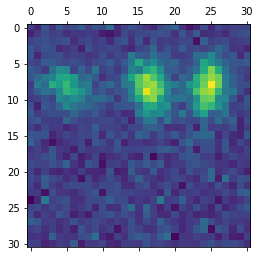

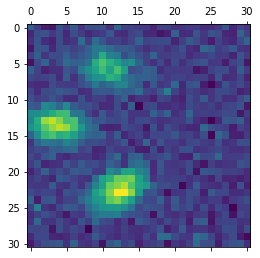

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [8]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [9]:
state_dict = torch.load('../galaxy_results/multiple_detections/' + \
                        'galaxy_vae_3detections_imp_sample_off_epoch200.dat', 
                        map_location='cpu')
galaxy_rnn.load_state_dict(state_dict, strict = True)

In [10]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

In [11]:
_, loss, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = True,
                                            use_baseline = False,
                                            max_detections = 3)

print(loss)

tensor(56166.7305)


In [12]:
_, loss, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = False,
                                            use_baseline = False,
                                            max_detections = 3)

print(loss)

tensor(27078.2500)


In [13]:
pixel_probs = galaxy_rnn.get_pixel_probs(resid_image = images_batch1 - backgrounds_batch1, 
                                         var_so_far = backgrounds_batch1)

In [14]:
torch.max(pixel_probs, dim = 1)

(tensor([ 0.7665,  0.2230,  0.8376,  0.3359,  0.9164,  0.6227,  0.1493,
          0.4578,  0.8233,  0.9484]),
 tensor([ 137,   96,  161,  498,  277,  182,  220,  303,  112,  422]))

In [15]:
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)

prob off:  [5.0030828e-17]


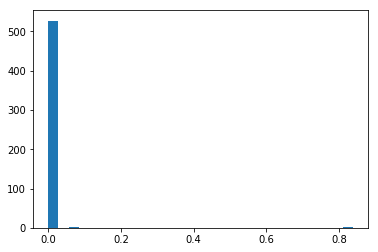

In [16]:
n = 2
plt.hist(pixel_probs[n, :].detach(), bins = 30); 
print('prob off: ', prob_off[n].detach().numpy())

In [17]:
attn_offset = galaxy_rnn.attn_offset

importance_weights = \
    imp_lib.get_importance_weights(torch.abs(images_batch1 - backgrounds_batch1), attn_offset, prob_off)

prob off:  [5.0030828e-17]


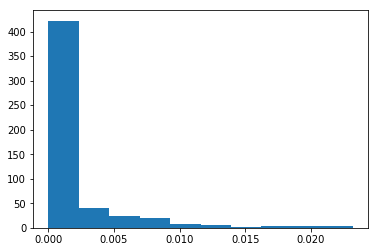

In [18]:
plt.hist(importance_weights[n, :]); 
print('prob off: ', prob_off[n].detach().numpy())

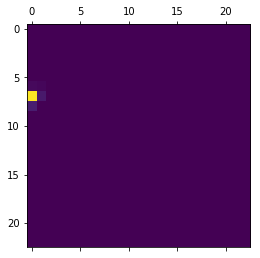

In [19]:
plt.matshow(pixel_probs[n, 0:-1].view(23, 23).detach())

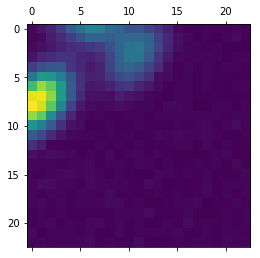

In [20]:
plt.matshow(importance_weights[n, 0:-1].view(23, 23))

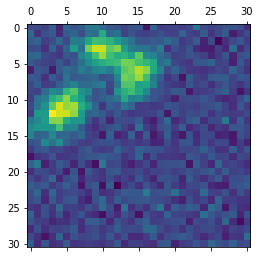

In [21]:
plt.matshow(images_batch1[n, 0, :, :])

In [25]:
_, loss, recon_means = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    use_importance_sample = False,
                                    use_baseline = False,
                                    max_detections = 3)

In [26]:
loss

tensor(26414.8633)

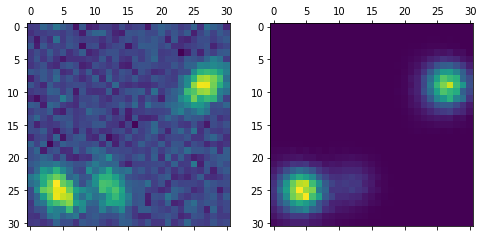

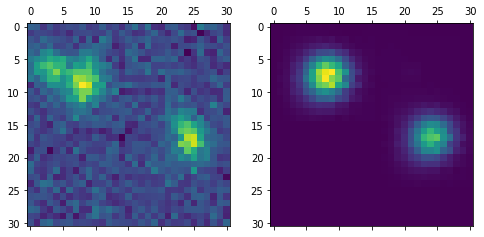

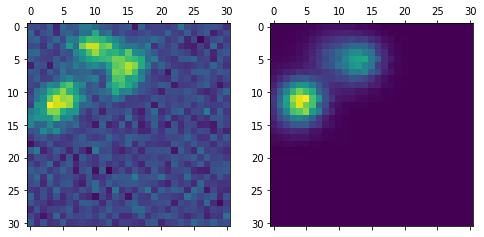

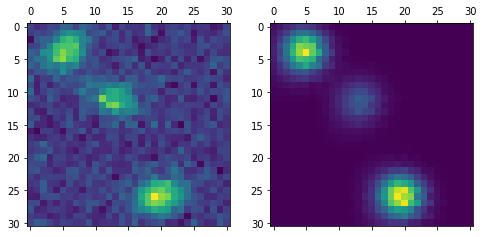

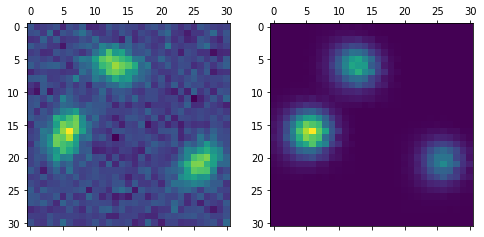

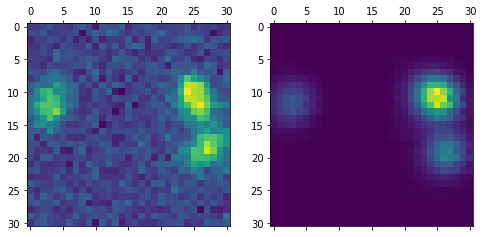

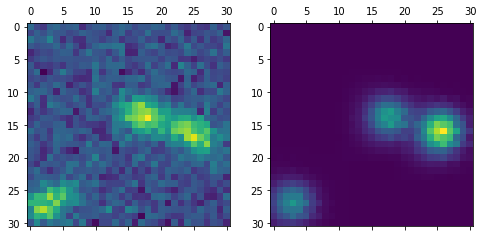

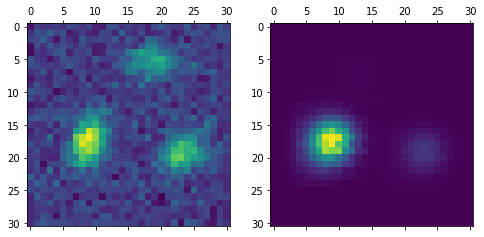

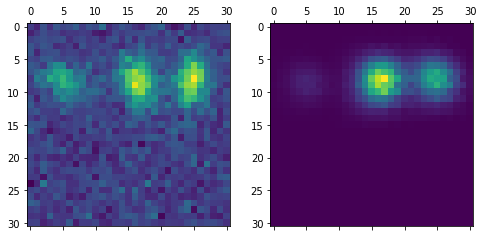

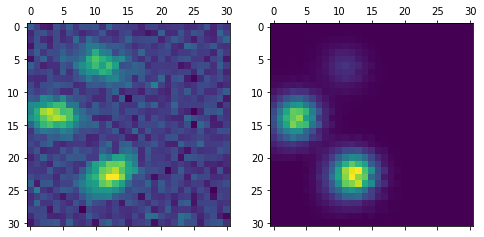

In [27]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_means.detach()[n, 0, :, :].squeeze())


In [28]:
# loss_array_imp_sample = np.load('../galaxy_results/multiple_detections/' + 
#                                 'galaxy_vae_3detections_batch_losses_array.npy')
loss_array_default = np.load('../galaxy_results/multiple_detections/galaxy_vae_3detections_imp_sample_off_test_losses_array.npy')

In [29]:
fontsize = 18

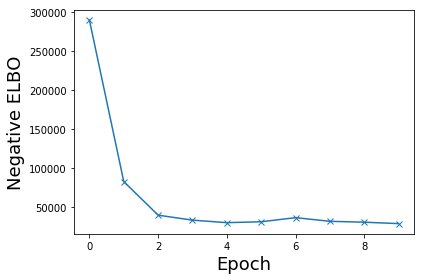

In [30]:
# plt.plot(np.minimum(loss_array_imp_sample, 1e6), '-x')
plt.plot(loss_array_default[0:10], '-x')

plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Negative ELBO', fontsize = fontsize)
# plt.legend(('REINFORCE + CV', 'Rao-Blackwellized'))
plt.tight_layout()